In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import zipfile
from torch.utils.data.sampler import SubsetRandomSampler


%matplotlib inline

In [2]:
images = np.load("/kaggle/input/olivetti/olivetti_faces.npy")
images.shape

(400, 64, 64)

In [3]:
import torchvision.transforms as transforms

img_transform = transforms.Compose([
    transforms.ToTensor()
])

class FaceDataset(Dataset):
    
    def __init__(self,images,transform):
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        
        img = self.images[idx]
        img = self.transform(img)
        img = img.numpy()
        
        return img.astype('float32')


face_dataset = FaceDataset(images,img_transform)
    
    
validation_split = .05
shuffle_dataset = True


dataset_size = len(face_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


trainloader = DataLoader(face_dataset, batch_size = 32,num_workers=4,sampler = train_sampler)
valloader = DataLoader(face_dataset, batch_size = 32,num_workers=4,sampler = valid_sampler)

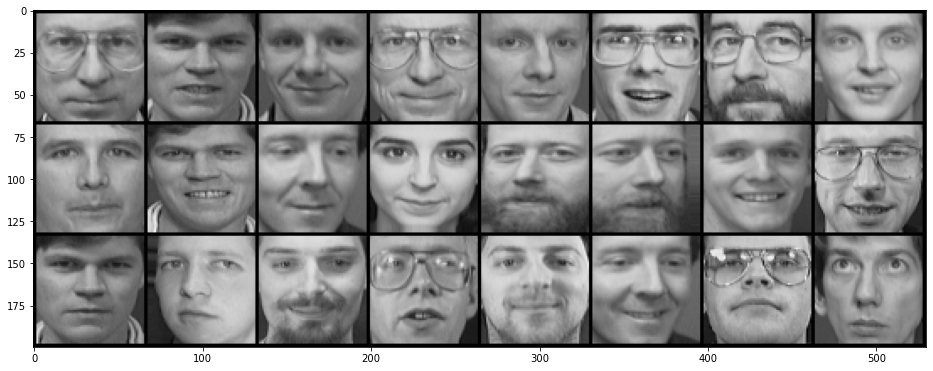

In [4]:
samples = iter(trainloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

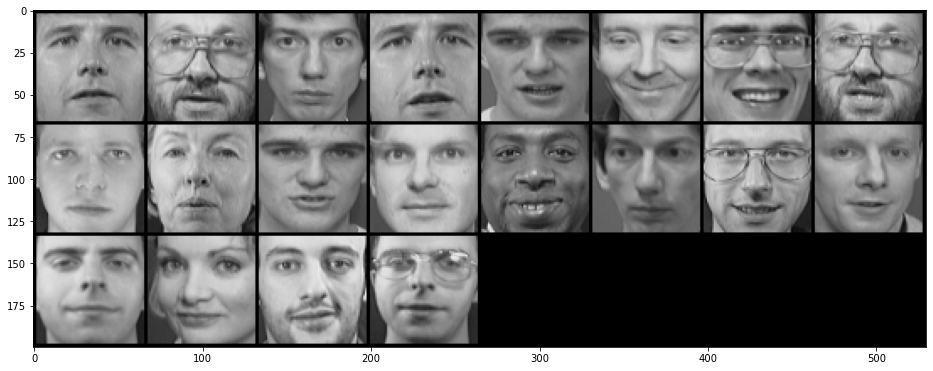

In [5]:
samples = iter(trainloader).next()
plt.figure(figsize=(16,20))
grid_imgs = torchvision.utils.make_grid(samples[:20])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [6]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [7]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(1,32,3,(1,1),padding=(1,1))
        self.conv2 = nn.Conv2d(32,64,2,(2,2),padding=(1,1))
        self.conv3 = nn.Conv2d(64,64,3,(1,1),padding=(1,1))
        self.conv4 = nn.Conv2d(64,128,4,(2,2),padding=(1,1))
        self.conv5 = nn.Conv2d(128,256,4,(2,2),padding=(1,1))
        self.conv_mu = nn.Conv2d(256,512,4,(2,2),padding=(1,1))
        self.conv_logvar = nn.Conv2d(256,512,4,(2,2),padding=(1,1))
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        
        return mu,logvar

In [8]:

class Decoder(nn.Module):
    
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.t_conv1 = nn.ConvTranspose2d(512,256,1,(1,1))
        self.t_conv2 = nn.ConvTranspose2d(256,256,1,(1,1))
        self.t_conv3 = nn.ConvTranspose2d(256,128,4,(2,2),padding=(1,1))
        self.t_conv4 = nn.ConvTranspose2d(128,64,4,(2,2),padding=(1,1))
        self.t_conv5 = nn.ConvTranspose2d(64,32,4,(2,2),padding=(1,1))
        self.t_conv6 = nn.ConvTranspose2d(32,1,4,(2,2),padding=(1,1))
        
    def forward(self,x):
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = F.relu(self.t_conv5(x))
        x = F.sigmoid(self.t_conv6(x))
        
        return x

In [9]:
class VAE(nn.Module):

  def __init__(self):
    super(VAE, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  def reparametrize(self,mu,logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.empty_like(std).normal_()
    return eps.mul(std).add_(mu)
  
  def forward(self,x):
    
    mu,logvar = self.encoder(x)
    z = self.reparametrize(mu,logvar)
    x = self.decoder(z)
   
    return (x,mu,logvar)

vae = VAE()
vae = vae.to(device)
print(vae)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_mu): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_logvar): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Decoder(
    (t_conv1): ConvTranspose2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (t_conv2): ConvTranspose2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (t_conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (t_conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (t_conv5): ConvTranspose2d(64, 32, kernel

In [10]:
def vae_loss(recon_x,x,mu,logvar):

  bce_loss = F.binary_cross_entropy(recon_x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]),x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]),reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return KLD + bce_loss

In [11]:
optimizer = torch.optim.Adam(vae.parameters(),0.001,weight_decay=1e-5)

In [13]:
vae.train()

train_loss_avg = []
num_epochs = 5000

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch in trainloader:
        
        image_batch = image_batch.to(device)

        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1,num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 5000] average reconstruction error: 83659.173177
Epoch [2 / 5000] average reconstruction error: 83654.335286
Epoch [3 / 5000] average reconstruction error: 83663.543620
Epoch [4 / 5000] average reconstruction error: 83664.299479
Epoch [5 / 5000] average reconstruction error: 83656.445964
Epoch [6 / 5000] average reconstruction error: 83674.076823
Epoch [7 / 5000] average reconstruction error: 83657.563151
Epoch [8 / 5000] average reconstruction error: 83675.239583
Epoch [9 / 5000] average reconstruction error: 83659.210286
Epoch [10 / 5000] average reconstruction error: 83657.308594
Epoch [11 / 5000] average reconstruction error: 83651.559245
Epoch [12 / 5000] average reconstruction error: 83657.944010
Epoch [13 / 5000] average reconstruction error: 83646.262370
Epoch [14 / 5000] average reconstruction error: 83662.017578
Epoch [15 / 5000] average reconstruction error: 83656.429036
Epoch [16 / 5000] average reconstruction error: 83661.557292
Epoch [17 / 5000] av

Epoch [135 / 5000] average reconstruction error: 83531.735677
Epoch [136 / 5000] average reconstruction error: 83532.029948
Epoch [137 / 5000] average reconstruction error: 83528.750000
Epoch [138 / 5000] average reconstruction error: 83541.920573
Epoch [139 / 5000] average reconstruction error: 83506.787109
Epoch [140 / 5000] average reconstruction error: 83522.970703
Epoch [141 / 5000] average reconstruction error: 83533.409505
Epoch [142 / 5000] average reconstruction error: 83552.514323
Epoch [143 / 5000] average reconstruction error: 83533.918620
Epoch [144 / 5000] average reconstruction error: 83515.104818
Epoch [145 / 5000] average reconstruction error: 83511.270182
Epoch [146 / 5000] average reconstruction error: 83513.427734
Epoch [147 / 5000] average reconstruction error: 83522.412760
Epoch [148 / 5000] average reconstruction error: 83517.325521
Epoch [149 / 5000] average reconstruction error: 83536.911458
Epoch [150 / 5000] average reconstruction error: 83511.301432
Epoch [1

Epoch [268 / 5000] average reconstruction error: 83439.324870
Epoch [269 / 5000] average reconstruction error: 83424.431641
Epoch [270 / 5000] average reconstruction error: 83434.047526
Epoch [271 / 5000] average reconstruction error: 83435.912760
Epoch [272 / 5000] average reconstruction error: 83431.241536
Epoch [273 / 5000] average reconstruction error: 83439.651693
Epoch [274 / 5000] average reconstruction error: 83419.985026
Epoch [275 / 5000] average reconstruction error: 83426.022786
Epoch [276 / 5000] average reconstruction error: 83418.278646
Epoch [277 / 5000] average reconstruction error: 83413.395833
Epoch [278 / 5000] average reconstruction error: 83411.325521
Epoch [279 / 5000] average reconstruction error: 83409.547526
Epoch [280 / 5000] average reconstruction error: 83428.942057
Epoch [281 / 5000] average reconstruction error: 83447.501953
Epoch [282 / 5000] average reconstruction error: 83447.570312
Epoch [283 / 5000] average reconstruction error: 83446.365234
Epoch [2

Epoch [401 / 5000] average reconstruction error: 83359.430339
Epoch [402 / 5000] average reconstruction error: 83367.832031
Epoch [403 / 5000] average reconstruction error: 83367.371094
Epoch [404 / 5000] average reconstruction error: 83352.513021
Epoch [405 / 5000] average reconstruction error: 83357.208333
Epoch [406 / 5000] average reconstruction error: 83378.873698
Epoch [407 / 5000] average reconstruction error: 83370.733724
Epoch [408 / 5000] average reconstruction error: 83352.439453
Epoch [409 / 5000] average reconstruction error: 83357.729818
Epoch [410 / 5000] average reconstruction error: 83339.967448
Epoch [411 / 5000] average reconstruction error: 83338.572266
Epoch [412 / 5000] average reconstruction error: 83362.233073
Epoch [413 / 5000] average reconstruction error: 83366.572266
Epoch [414 / 5000] average reconstruction error: 83348.113281
Epoch [415 / 5000] average reconstruction error: 83372.521484
Epoch [416 / 5000] average reconstruction error: 83354.264974
Epoch [4

Epoch [534 / 5000] average reconstruction error: 83324.820312
Epoch [535 / 5000] average reconstruction error: 83327.476562
Epoch [536 / 5000] average reconstruction error: 83336.032552
Epoch [537 / 5000] average reconstruction error: 83319.942057
Epoch [538 / 5000] average reconstruction error: 83320.149740
Epoch [539 / 5000] average reconstruction error: 83334.718750
Epoch [540 / 5000] average reconstruction error: 83305.556641
Epoch [541 / 5000] average reconstruction error: 83309.007812
Epoch [542 / 5000] average reconstruction error: 83311.359375
Epoch [543 / 5000] average reconstruction error: 83289.188802
Epoch [544 / 5000] average reconstruction error: 83296.200521
Epoch [545 / 5000] average reconstruction error: 83320.508464
Epoch [546 / 5000] average reconstruction error: 83309.899089
Epoch [547 / 5000] average reconstruction error: 83301.353516
Epoch [548 / 5000] average reconstruction error: 83288.708333
Epoch [549 / 5000] average reconstruction error: 83313.869792
Epoch [5

Epoch [667 / 5000] average reconstruction error: 83268.867839
Epoch [668 / 5000] average reconstruction error: 83268.070964
Epoch [669 / 5000] average reconstruction error: 83265.888021
Epoch [670 / 5000] average reconstruction error: 83263.178385
Epoch [671 / 5000] average reconstruction error: 83257.245443
Epoch [672 / 5000] average reconstruction error: 83269.865234
Epoch [673 / 5000] average reconstruction error: 83261.548828
Epoch [674 / 5000] average reconstruction error: 83272.154948
Epoch [675 / 5000] average reconstruction error: 83305.249349
Epoch [676 / 5000] average reconstruction error: 83274.057943
Epoch [677 / 5000] average reconstruction error: 83274.809896
Epoch [678 / 5000] average reconstruction error: 83282.595703
Epoch [679 / 5000] average reconstruction error: 83264.946615
Epoch [680 / 5000] average reconstruction error: 83251.085286
Epoch [681 / 5000] average reconstruction error: 83262.399089
Epoch [682 / 5000] average reconstruction error: 83267.729818
Epoch [6

Epoch [800 / 5000] average reconstruction error: 83237.697266
Epoch [801 / 5000] average reconstruction error: 83241.354818
Epoch [802 / 5000] average reconstruction error: 83241.138672
Epoch [803 / 5000] average reconstruction error: 83242.720052
Epoch [804 / 5000] average reconstruction error: 83244.709635
Epoch [805 / 5000] average reconstruction error: 83233.937500
Epoch [806 / 5000] average reconstruction error: 83235.529297
Epoch [807 / 5000] average reconstruction error: 83258.045573
Epoch [808 / 5000] average reconstruction error: 83257.995443
Epoch [809 / 5000] average reconstruction error: 83274.973958
Epoch [810 / 5000] average reconstruction error: 83261.408854
Epoch [811 / 5000] average reconstruction error: 83250.807943
Epoch [812 / 5000] average reconstruction error: 83254.655599
Epoch [813 / 5000] average reconstruction error: 83256.300130
Epoch [814 / 5000] average reconstruction error: 83246.658203
Epoch [815 / 5000] average reconstruction error: 83242.777995
Epoch [8

Epoch [933 / 5000] average reconstruction error: 83225.407552
Epoch [934 / 5000] average reconstruction error: 83207.143229
Epoch [935 / 5000] average reconstruction error: 83232.535156
Epoch [936 / 5000] average reconstruction error: 83219.707031
Epoch [937 / 5000] average reconstruction error: 83212.850260
Epoch [938 / 5000] average reconstruction error: 83215.722005
Epoch [939 / 5000] average reconstruction error: 83216.678385
Epoch [940 / 5000] average reconstruction error: 83217.494141
Epoch [941 / 5000] average reconstruction error: 83209.685547
Epoch [942 / 5000] average reconstruction error: 83218.603516
Epoch [943 / 5000] average reconstruction error: 83219.664714
Epoch [944 / 5000] average reconstruction error: 83224.491536
Epoch [945 / 5000] average reconstruction error: 83222.319010
Epoch [946 / 5000] average reconstruction error: 83225.396484
Epoch [947 / 5000] average reconstruction error: 83213.567708
Epoch [948 / 5000] average reconstruction error: 83209.773438
Epoch [9

Epoch [1065 / 5000] average reconstruction error: 83196.430339
Epoch [1066 / 5000] average reconstruction error: 83194.984375
Epoch [1067 / 5000] average reconstruction error: 83198.873698
Epoch [1068 / 5000] average reconstruction error: 83202.455729
Epoch [1069 / 5000] average reconstruction error: 83219.899089
Epoch [1070 / 5000] average reconstruction error: 83189.026042
Epoch [1071 / 5000] average reconstruction error: 83198.705078
Epoch [1072 / 5000] average reconstruction error: 83200.383464
Epoch [1073 / 5000] average reconstruction error: 83197.572266
Epoch [1074 / 5000] average reconstruction error: 83199.640625
Epoch [1075 / 5000] average reconstruction error: 83202.519531
Epoch [1076 / 5000] average reconstruction error: 83187.330729
Epoch [1077 / 5000] average reconstruction error: 83193.991536
Epoch [1078 / 5000] average reconstruction error: 83191.065104
Epoch [1079 / 5000] average reconstruction error: 83216.149740
Epoch [1080 / 5000] average reconstruction error: 83217

Epoch [1196 / 5000] average reconstruction error: 83166.163411
Epoch [1197 / 5000] average reconstruction error: 83189.346354
Epoch [1198 / 5000] average reconstruction error: 83176.431641
Epoch [1199 / 5000] average reconstruction error: 83179.621094
Epoch [1200 / 5000] average reconstruction error: 83192.547526
Epoch [1201 / 5000] average reconstruction error: 83188.973307
Epoch [1202 / 5000] average reconstruction error: 83193.493490
Epoch [1203 / 5000] average reconstruction error: 83173.587240
Epoch [1204 / 5000] average reconstruction error: 83188.842448
Epoch [1205 / 5000] average reconstruction error: 83189.748047
Epoch [1206 / 5000] average reconstruction error: 83194.050781
Epoch [1207 / 5000] average reconstruction error: 83178.419922
Epoch [1208 / 5000] average reconstruction error: 83178.468099
Epoch [1209 / 5000] average reconstruction error: 83179.539714
Epoch [1210 / 5000] average reconstruction error: 83179.745443
Epoch [1211 / 5000] average reconstruction error: 83186

Epoch [1327 / 5000] average reconstruction error: 83159.149740
Epoch [1328 / 5000] average reconstruction error: 83168.098307
Epoch [1329 / 5000] average reconstruction error: 83166.410156
Epoch [1330 / 5000] average reconstruction error: 83178.634766
Epoch [1331 / 5000] average reconstruction error: 83168.212240
Epoch [1332 / 5000] average reconstruction error: 83180.306641
Epoch [1333 / 5000] average reconstruction error: 83168.459635
Epoch [1334 / 5000] average reconstruction error: 83171.709635
Epoch [1335 / 5000] average reconstruction error: 83160.744141
Epoch [1336 / 5000] average reconstruction error: 83158.198568
Epoch [1337 / 5000] average reconstruction error: 83164.322917
Epoch [1338 / 5000] average reconstruction error: 83175.074870
Epoch [1339 / 5000] average reconstruction error: 83159.998698
Epoch [1340 / 5000] average reconstruction error: 83169.789062
Epoch [1341 / 5000] average reconstruction error: 83170.842448
Epoch [1342 / 5000] average reconstruction error: 83173

Epoch [1458 / 5000] average reconstruction error: 83157.849609
Epoch [1459 / 5000] average reconstruction error: 83156.899089
Epoch [1460 / 5000] average reconstruction error: 83160.471354
Epoch [1461 / 5000] average reconstruction error: 83165.038411
Epoch [1462 / 5000] average reconstruction error: 83147.458984
Epoch [1463 / 5000] average reconstruction error: 83166.143880
Epoch [1464 / 5000] average reconstruction error: 83163.518229
Epoch [1465 / 5000] average reconstruction error: 83152.902995
Epoch [1466 / 5000] average reconstruction error: 83159.822917
Epoch [1467 / 5000] average reconstruction error: 83147.798828
Epoch [1468 / 5000] average reconstruction error: 83151.016276
Epoch [1469 / 5000] average reconstruction error: 83149.848958
Epoch [1470 / 5000] average reconstruction error: 83169.467448
Epoch [1471 / 5000] average reconstruction error: 83158.124349
Epoch [1472 / 5000] average reconstruction error: 83150.157552
Epoch [1473 / 5000] average reconstruction error: 83136

Epoch [1589 / 5000] average reconstruction error: 83152.902344
Epoch [1590 / 5000] average reconstruction error: 83132.188151
Epoch [1591 / 5000] average reconstruction error: 83134.671875
Epoch [1592 / 5000] average reconstruction error: 83139.945312
Epoch [1593 / 5000] average reconstruction error: 83132.849609
Epoch [1594 / 5000] average reconstruction error: 83142.874349
Epoch [1595 / 5000] average reconstruction error: 83148.120443
Epoch [1596 / 5000] average reconstruction error: 83142.027995
Epoch [1597 / 5000] average reconstruction error: 83145.764974
Epoch [1598 / 5000] average reconstruction error: 83134.273438
Epoch [1599 / 5000] average reconstruction error: 83145.231771
Epoch [1600 / 5000] average reconstruction error: 83144.431641
Epoch [1601 / 5000] average reconstruction error: 83152.669271
Epoch [1602 / 5000] average reconstruction error: 83149.936198
Epoch [1603 / 5000] average reconstruction error: 83157.770182
Epoch [1604 / 5000] average reconstruction error: 83154

Epoch [1720 / 5000] average reconstruction error: 83116.799479
Epoch [1721 / 5000] average reconstruction error: 83131.347656
Epoch [1722 / 5000] average reconstruction error: 83124.336589
Epoch [1723 / 5000] average reconstruction error: 83148.174479
Epoch [1724 / 5000] average reconstruction error: 83115.743490
Epoch [1725 / 5000] average reconstruction error: 83121.352214
Epoch [1726 / 5000] average reconstruction error: 83137.344401
Epoch [1727 / 5000] average reconstruction error: 83146.630208
Epoch [1728 / 5000] average reconstruction error: 83138.470052
Epoch [1729 / 5000] average reconstruction error: 83139.383464
Epoch [1730 / 5000] average reconstruction error: 83152.993490
Epoch [1731 / 5000] average reconstruction error: 83136.039062
Epoch [1732 / 5000] average reconstruction error: 83132.165365
Epoch [1733 / 5000] average reconstruction error: 83122.823568
Epoch [1734 / 5000] average reconstruction error: 83134.430339
Epoch [1735 / 5000] average reconstruction error: 83130

Epoch [1851 / 5000] average reconstruction error: 83104.009766
Epoch [1852 / 5000] average reconstruction error: 83110.794922
Epoch [1853 / 5000] average reconstruction error: 83120.435547
Epoch [1854 / 5000] average reconstruction error: 83106.546875
Epoch [1855 / 5000] average reconstruction error: 83109.305990
Epoch [1856 / 5000] average reconstruction error: 83129.640625
Epoch [1857 / 5000] average reconstruction error: 83111.392578
Epoch [1858 / 5000] average reconstruction error: 83126.016927
Epoch [1859 / 5000] average reconstruction error: 83113.361328
Epoch [1860 / 5000] average reconstruction error: 83130.299479
Epoch [1861 / 5000] average reconstruction error: 83124.328776
Epoch [1862 / 5000] average reconstruction error: 83109.719401
Epoch [1863 / 5000] average reconstruction error: 83123.869792
Epoch [1864 / 5000] average reconstruction error: 83122.704427
Epoch [1865 / 5000] average reconstruction error: 83120.288411
Epoch [1866 / 5000] average reconstruction error: 83125

Epoch [1982 / 5000] average reconstruction error: 83114.743490
Epoch [1983 / 5000] average reconstruction error: 83119.494141
Epoch [1984 / 5000] average reconstruction error: 83114.567708
Epoch [1985 / 5000] average reconstruction error: 83120.750651
Epoch [1986 / 5000] average reconstruction error: 83116.392578
Epoch [1987 / 5000] average reconstruction error: 83109.490234
Epoch [1988 / 5000] average reconstruction error: 83105.761068
Epoch [1989 / 5000] average reconstruction error: 83098.119792
Epoch [1990 / 5000] average reconstruction error: 83118.789714
Epoch [1991 / 5000] average reconstruction error: 83130.697266
Epoch [1992 / 5000] average reconstruction error: 83100.214193
Epoch [1993 / 5000] average reconstruction error: 83100.121745
Epoch [1994 / 5000] average reconstruction error: 83113.242188
Epoch [1995 / 5000] average reconstruction error: 83113.944010
Epoch [1996 / 5000] average reconstruction error: 83106.461589
Epoch [1997 / 5000] average reconstruction error: 83105

Epoch [2113 / 5000] average reconstruction error: 83103.606120
Epoch [2114 / 5000] average reconstruction error: 83104.645833
Epoch [2115 / 5000] average reconstruction error: 83106.917969
Epoch [2116 / 5000] average reconstruction error: 83102.950521
Epoch [2117 / 5000] average reconstruction error: 83113.839193
Epoch [2118 / 5000] average reconstruction error: 83108.412760
Epoch [2119 / 5000] average reconstruction error: 83108.323568
Epoch [2120 / 5000] average reconstruction error: 83128.233724
Epoch [2121 / 5000] average reconstruction error: 83108.191406
Epoch [2122 / 5000] average reconstruction error: 83098.042969
Epoch [2123 / 5000] average reconstruction error: 83102.581380
Epoch [2124 / 5000] average reconstruction error: 83097.977865
Epoch [2125 / 5000] average reconstruction error: 83095.233073
Epoch [2126 / 5000] average reconstruction error: 83097.015625
Epoch [2127 / 5000] average reconstruction error: 83090.380208
Epoch [2128 / 5000] average reconstruction error: 83101

Epoch [2244 / 5000] average reconstruction error: 83089.880208
Epoch [2245 / 5000] average reconstruction error: 83096.518229
Epoch [2246 / 5000] average reconstruction error: 83099.347656
Epoch [2247 / 5000] average reconstruction error: 83097.098307
Epoch [2248 / 5000] average reconstruction error: 83103.737630
Epoch [2249 / 5000] average reconstruction error: 83124.044922
Epoch [2250 / 5000] average reconstruction error: 83114.218750
Epoch [2251 / 5000] average reconstruction error: 83088.661458
Epoch [2252 / 5000] average reconstruction error: 83075.017578
Epoch [2253 / 5000] average reconstruction error: 83085.776693
Epoch [2254 / 5000] average reconstruction error: 83094.875000
Epoch [2255 / 5000] average reconstruction error: 83101.029297
Epoch [2256 / 5000] average reconstruction error: 83098.153646
Epoch [2257 / 5000] average reconstruction error: 83092.701823
Epoch [2258 / 5000] average reconstruction error: 83085.554688
Epoch [2259 / 5000] average reconstruction error: 83095

Epoch [2375 / 5000] average reconstruction error: 83102.629557
Epoch [2376 / 5000] average reconstruction error: 83066.713542
Epoch [2377 / 5000] average reconstruction error: 83093.268229
Epoch [2378 / 5000] average reconstruction error: 83080.563802
Epoch [2379 / 5000] average reconstruction error: 83096.593750
Epoch [2380 / 5000] average reconstruction error: 83087.394531
Epoch [2381 / 5000] average reconstruction error: 83084.315755
Epoch [2382 / 5000] average reconstruction error: 83097.177083
Epoch [2383 / 5000] average reconstruction error: 83089.723307
Epoch [2384 / 5000] average reconstruction error: 83091.364583
Epoch [2385 / 5000] average reconstruction error: 83087.382161
Epoch [2386 / 5000] average reconstruction error: 83082.701172
Epoch [2387 / 5000] average reconstruction error: 83087.628255
Epoch [2388 / 5000] average reconstruction error: 83096.341797
Epoch [2389 / 5000] average reconstruction error: 83085.980469
Epoch [2390 / 5000] average reconstruction error: 83083

Epoch [2506 / 5000] average reconstruction error: 83095.710286
Epoch [2507 / 5000] average reconstruction error: 83089.016276
Epoch [2508 / 5000] average reconstruction error: 83078.686198
Epoch [2509 / 5000] average reconstruction error: 83081.113932
Epoch [2510 / 5000] average reconstruction error: 83081.112630
Epoch [2511 / 5000] average reconstruction error: 83077.199870
Epoch [2512 / 5000] average reconstruction error: 83077.646484
Epoch [2513 / 5000] average reconstruction error: 83083.161458
Epoch [2514 / 5000] average reconstruction error: 83083.979818
Epoch [2515 / 5000] average reconstruction error: 83093.634766
Epoch [2516 / 5000] average reconstruction error: 83074.300130
Epoch [2517 / 5000] average reconstruction error: 83090.243490
Epoch [2518 / 5000] average reconstruction error: 83087.333333
Epoch [2519 / 5000] average reconstruction error: 83077.754557
Epoch [2520 / 5000] average reconstruction error: 83079.613932
Epoch [2521 / 5000] average reconstruction error: 83077

Epoch [2637 / 5000] average reconstruction error: 83081.682292
Epoch [2638 / 5000] average reconstruction error: 83076.908854
Epoch [2639 / 5000] average reconstruction error: 83098.600911
Epoch [2640 / 5000] average reconstruction error: 83069.110026
Epoch [2641 / 5000] average reconstruction error: 83078.201172
Epoch [2642 / 5000] average reconstruction error: 83075.192708
Epoch [2643 / 5000] average reconstruction error: 83080.460938
Epoch [2644 / 5000] average reconstruction error: 83068.479167
Epoch [2645 / 5000] average reconstruction error: 83072.438151
Epoch [2646 / 5000] average reconstruction error: 83079.212240
Epoch [2647 / 5000] average reconstruction error: 83079.283854
Epoch [2648 / 5000] average reconstruction error: 83063.702474
Epoch [2649 / 5000] average reconstruction error: 83060.151693
Epoch [2650 / 5000] average reconstruction error: 83069.777995
Epoch [2651 / 5000] average reconstruction error: 83076.398438
Epoch [2652 / 5000] average reconstruction error: 83068

Epoch [2768 / 5000] average reconstruction error: 83081.901693
Epoch [2769 / 5000] average reconstruction error: 83080.253906
Epoch [2770 / 5000] average reconstruction error: 83080.582031
Epoch [2771 / 5000] average reconstruction error: 83072.733724
Epoch [2772 / 5000] average reconstruction error: 83077.982422
Epoch [2773 / 5000] average reconstruction error: 83067.742839
Epoch [2774 / 5000] average reconstruction error: 83077.264974
Epoch [2775 / 5000] average reconstruction error: 83074.154948
Epoch [2776 / 5000] average reconstruction error: 83066.755859
Epoch [2777 / 5000] average reconstruction error: 83072.916667
Epoch [2778 / 5000] average reconstruction error: 83065.591797
Epoch [2779 / 5000] average reconstruction error: 83062.465495
Epoch [2780 / 5000] average reconstruction error: 83075.239583
Epoch [2781 / 5000] average reconstruction error: 83062.748698
Epoch [2782 / 5000] average reconstruction error: 83082.777995
Epoch [2783 / 5000] average reconstruction error: 83074

Epoch [2899 / 5000] average reconstruction error: 83068.496094
Epoch [2900 / 5000] average reconstruction error: 83066.581380
Epoch [2901 / 5000] average reconstruction error: 83063.802083
Epoch [2902 / 5000] average reconstruction error: 83064.421875
Epoch [2903 / 5000] average reconstruction error: 83065.695964
Epoch [2904 / 5000] average reconstruction error: 83066.034505
Epoch [2905 / 5000] average reconstruction error: 83060.417318
Epoch [2906 / 5000] average reconstruction error: 83071.254557
Epoch [2907 / 5000] average reconstruction error: 83072.248698
Epoch [2908 / 5000] average reconstruction error: 83078.756510
Epoch [2909 / 5000] average reconstruction error: 83069.537760
Epoch [2910 / 5000] average reconstruction error: 83070.500651
Epoch [2911 / 5000] average reconstruction error: 83070.906250
Epoch [2912 / 5000] average reconstruction error: 83067.701823
Epoch [2913 / 5000] average reconstruction error: 83075.015625
Epoch [2914 / 5000] average reconstruction error: 83067

Epoch [3030 / 5000] average reconstruction error: 83067.393880
Epoch [3031 / 5000] average reconstruction error: 83061.312500
Epoch [3032 / 5000] average reconstruction error: 83084.642578
Epoch [3033 / 5000] average reconstruction error: 83066.636068
Epoch [3034 / 5000] average reconstruction error: 83063.235026
Epoch [3035 / 5000] average reconstruction error: 83053.207682
Epoch [3036 / 5000] average reconstruction error: 83061.947266
Epoch [3037 / 5000] average reconstruction error: 83051.475911
Epoch [3038 / 5000] average reconstruction error: 83053.119792
Epoch [3039 / 5000] average reconstruction error: 83045.526693
Epoch [3040 / 5000] average reconstruction error: 83049.136719
Epoch [3041 / 5000] average reconstruction error: 83056.505859
Epoch [3042 / 5000] average reconstruction error: 83063.639974
Epoch [3043 / 5000] average reconstruction error: 83063.156901
Epoch [3044 / 5000] average reconstruction error: 83059.087891
Epoch [3045 / 5000] average reconstruction error: 83075

Epoch [3161 / 5000] average reconstruction error: 83064.468099
Epoch [3162 / 5000] average reconstruction error: 83059.436198
Epoch [3163 / 5000] average reconstruction error: 83078.668620
Epoch [3164 / 5000] average reconstruction error: 83065.733724
Epoch [3165 / 5000] average reconstruction error: 83061.746094
Epoch [3166 / 5000] average reconstruction error: 83055.333333
Epoch [3167 / 5000] average reconstruction error: 83056.746745
Epoch [3168 / 5000] average reconstruction error: 83056.347656
Epoch [3169 / 5000] average reconstruction error: 83072.460938
Epoch [3170 / 5000] average reconstruction error: 83060.929036
Epoch [3171 / 5000] average reconstruction error: 83041.720052
Epoch [3172 / 5000] average reconstruction error: 83065.363281
Epoch [3173 / 5000] average reconstruction error: 83071.901693
Epoch [3174 / 5000] average reconstruction error: 83058.552083
Epoch [3175 / 5000] average reconstruction error: 83065.908203
Epoch [3176 / 5000] average reconstruction error: 83081

Epoch [3292 / 5000] average reconstruction error: 83056.207031
Epoch [3293 / 5000] average reconstruction error: 83051.063802
Epoch [3294 / 5000] average reconstruction error: 83053.019531
Epoch [3295 / 5000] average reconstruction error: 83050.126302
Epoch [3296 / 5000] average reconstruction error: 83046.791667
Epoch [3297 / 5000] average reconstruction error: 83059.300781
Epoch [3298 / 5000] average reconstruction error: 83047.725911
Epoch [3299 / 5000] average reconstruction error: 83056.200521
Epoch [3300 / 5000] average reconstruction error: 83061.570964
Epoch [3301 / 5000] average reconstruction error: 83059.865885
Epoch [3302 / 5000] average reconstruction error: 83051.133464
Epoch [3303 / 5000] average reconstruction error: 83044.839844
Epoch [3304 / 5000] average reconstruction error: 83068.376302
Epoch [3305 / 5000] average reconstruction error: 83055.652344
Epoch [3306 / 5000] average reconstruction error: 83054.181641
Epoch [3307 / 5000] average reconstruction error: 83048

Epoch [3423 / 5000] average reconstruction error: 83057.013021
Epoch [3424 / 5000] average reconstruction error: 83060.690755
Epoch [3425 / 5000] average reconstruction error: 83049.216146
Epoch [3426 / 5000] average reconstruction error: 83056.559896
Epoch [3427 / 5000] average reconstruction error: 83039.845052
Epoch [3428 / 5000] average reconstruction error: 83038.006510
Epoch [3429 / 5000] average reconstruction error: 83035.054036
Epoch [3430 / 5000] average reconstruction error: 83048.161458
Epoch [3431 / 5000] average reconstruction error: 83050.352214
Epoch [3432 / 5000] average reconstruction error: 83044.368490
Epoch [3433 / 5000] average reconstruction error: 83057.047526
Epoch [3434 / 5000] average reconstruction error: 83049.348958
Epoch [3435 / 5000] average reconstruction error: 83049.502604
Epoch [3436 / 5000] average reconstruction error: 83049.576172
Epoch [3437 / 5000] average reconstruction error: 83048.576823
Epoch [3438 / 5000] average reconstruction error: 83034

Epoch [3554 / 5000] average reconstruction error: 83050.145182
Epoch [3555 / 5000] average reconstruction error: 83056.453776
Epoch [3556 / 5000] average reconstruction error: 83062.142578
Epoch [3557 / 5000] average reconstruction error: 83042.994141
Epoch [3558 / 5000] average reconstruction error: 83040.940755
Epoch [3559 / 5000] average reconstruction error: 83035.875651
Epoch [3560 / 5000] average reconstruction error: 83041.402344
Epoch [3561 / 5000] average reconstruction error: 83039.039714
Epoch [3562 / 5000] average reconstruction error: 83045.201172
Epoch [3563 / 5000] average reconstruction error: 83035.073568
Epoch [3564 / 5000] average reconstruction error: 83036.645833
Epoch [3565 / 5000] average reconstruction error: 83044.717448
Epoch [3566 / 5000] average reconstruction error: 83036.624349
Epoch [3567 / 5000] average reconstruction error: 83047.977214
Epoch [3568 / 5000] average reconstruction error: 83040.068359
Epoch [3569 / 5000] average reconstruction error: 83045

Epoch [3685 / 5000] average reconstruction error: 83038.979818
Epoch [3686 / 5000] average reconstruction error: 83047.725260
Epoch [3687 / 5000] average reconstruction error: 83039.852865
Epoch [3688 / 5000] average reconstruction error: 83040.390625
Epoch [3689 / 5000] average reconstruction error: 83036.173177
Epoch [3690 / 5000] average reconstruction error: 83035.082031
Epoch [3691 / 5000] average reconstruction error: 83054.694661
Epoch [3692 / 5000] average reconstruction error: 83043.345052
Epoch [3693 / 5000] average reconstruction error: 83037.525391
Epoch [3694 / 5000] average reconstruction error: 83049.203776
Epoch [3695 / 5000] average reconstruction error: 83049.683594
Epoch [3696 / 5000] average reconstruction error: 83036.681641
Epoch [3697 / 5000] average reconstruction error: 83039.191406
Epoch [3698 / 5000] average reconstruction error: 83038.093750
Epoch [3699 / 5000] average reconstruction error: 83032.765625
Epoch [3700 / 5000] average reconstruction error: 83051

Epoch [3816 / 5000] average reconstruction error: 83045.393880
Epoch [3817 / 5000] average reconstruction error: 83024.789062
Epoch [3818 / 5000] average reconstruction error: 83042.184896
Epoch [3819 / 5000] average reconstruction error: 83039.787109
Epoch [3820 / 5000] average reconstruction error: 83038.065104
Epoch [3821 / 5000] average reconstruction error: 83040.567708
Epoch [3822 / 5000] average reconstruction error: 83034.059245
Epoch [3823 / 5000] average reconstruction error: 83034.154948
Epoch [3824 / 5000] average reconstruction error: 83042.447266
Epoch [3825 / 5000] average reconstruction error: 83042.222005
Epoch [3826 / 5000] average reconstruction error: 83036.172526
Epoch [3827 / 5000] average reconstruction error: 83041.919271
Epoch [3828 / 5000] average reconstruction error: 83047.556641
Epoch [3829 / 5000] average reconstruction error: 83052.466797
Epoch [3830 / 5000] average reconstruction error: 83051.131510
Epoch [3831 / 5000] average reconstruction error: 83054

Epoch [3947 / 5000] average reconstruction error: 83030.616536
Epoch [3948 / 5000] average reconstruction error: 83044.923828
Epoch [3949 / 5000] average reconstruction error: 83040.346354
Epoch [3950 / 5000] average reconstruction error: 83038.918620
Epoch [3951 / 5000] average reconstruction error: 83034.643229
Epoch [3952 / 5000] average reconstruction error: 83019.499349
Epoch [3953 / 5000] average reconstruction error: 83044.005208
Epoch [3954 / 5000] average reconstruction error: 83043.890625
Epoch [3955 / 5000] average reconstruction error: 83036.412760
Epoch [3956 / 5000] average reconstruction error: 83055.000000
Epoch [3957 / 5000] average reconstruction error: 83050.769531
Epoch [3958 / 5000] average reconstruction error: 83052.555990
Epoch [3959 / 5000] average reconstruction error: 83037.343750
Epoch [3960 / 5000] average reconstruction error: 83027.729818
Epoch [3961 / 5000] average reconstruction error: 83019.835938
Epoch [3962 / 5000] average reconstruction error: 83043

Epoch [4078 / 5000] average reconstruction error: 83031.048177
Epoch [4079 / 5000] average reconstruction error: 83032.915365
Epoch [4080 / 5000] average reconstruction error: 83030.255859
Epoch [4081 / 5000] average reconstruction error: 83033.063802
Epoch [4082 / 5000] average reconstruction error: 83032.511719
Epoch [4083 / 5000] average reconstruction error: 83032.912760
Epoch [4084 / 5000] average reconstruction error: 83029.212891
Epoch [4085 / 5000] average reconstruction error: 83061.615885
Epoch [4086 / 5000] average reconstruction error: 83047.942708
Epoch [4087 / 5000] average reconstruction error: 83029.384115
Epoch [4088 / 5000] average reconstruction error: 83045.889974
Epoch [4089 / 5000] average reconstruction error: 83020.623698
Epoch [4090 / 5000] average reconstruction error: 83021.255208
Epoch [4091 / 5000] average reconstruction error: 83031.282552
Epoch [4092 / 5000] average reconstruction error: 83041.493490
Epoch [4093 / 5000] average reconstruction error: 83031

Epoch [4209 / 5000] average reconstruction error: 83038.233724
Epoch [4210 / 5000] average reconstruction error: 83029.939453
Epoch [4211 / 5000] average reconstruction error: 83023.414714
Epoch [4212 / 5000] average reconstruction error: 83036.453776
Epoch [4213 / 5000] average reconstruction error: 83029.488281
Epoch [4214 / 5000] average reconstruction error: 83030.451172
Epoch [4215 / 5000] average reconstruction error: 83027.074870
Epoch [4216 / 5000] average reconstruction error: 83041.093099
Epoch [4217 / 5000] average reconstruction error: 83043.097656
Epoch [4218 / 5000] average reconstruction error: 83044.827474
Epoch [4219 / 5000] average reconstruction error: 83040.205729
Epoch [4220 / 5000] average reconstruction error: 83034.651693
Epoch [4221 / 5000] average reconstruction error: 83029.498698
Epoch [4222 / 5000] average reconstruction error: 83026.839193
Epoch [4223 / 5000] average reconstruction error: 83024.656250
Epoch [4224 / 5000] average reconstruction error: 83034

Epoch [4340 / 5000] average reconstruction error: 83030.962891
Epoch [4341 / 5000] average reconstruction error: 83038.198568
Epoch [4342 / 5000] average reconstruction error: 83038.850911
Epoch [4343 / 5000] average reconstruction error: 83043.122396
Epoch [4344 / 5000] average reconstruction error: 83035.692057
Epoch [4345 / 5000] average reconstruction error: 83031.063151
Epoch [4346 / 5000] average reconstruction error: 83034.490885
Epoch [4347 / 5000] average reconstruction error: 83023.294922
Epoch [4348 / 5000] average reconstruction error: 83025.126953
Epoch [4349 / 5000] average reconstruction error: 83022.795573
Epoch [4350 / 5000] average reconstruction error: 83033.511719
Epoch [4351 / 5000] average reconstruction error: 83014.090495
Epoch [4352 / 5000] average reconstruction error: 83038.246094
Epoch [4353 / 5000] average reconstruction error: 83039.257812
Epoch [4354 / 5000] average reconstruction error: 83032.257161
Epoch [4355 / 5000] average reconstruction error: 83026

Epoch [4471 / 5000] average reconstruction error: 83025.314453
Epoch [4472 / 5000] average reconstruction error: 83022.091146
Epoch [4473 / 5000] average reconstruction error: 83028.639974
Epoch [4474 / 5000] average reconstruction error: 83023.866536
Epoch [4475 / 5000] average reconstruction error: 83021.432292
Epoch [4476 / 5000] average reconstruction error: 83041.830078
Epoch [4477 / 5000] average reconstruction error: 83020.194010
Epoch [4478 / 5000] average reconstruction error: 83013.882161
Epoch [4479 / 5000] average reconstruction error: 83035.790365
Epoch [4480 / 5000] average reconstruction error: 83042.760417
Epoch [4481 / 5000] average reconstruction error: 83030.316406
Epoch [4482 / 5000] average reconstruction error: 83025.935547
Epoch [4483 / 5000] average reconstruction error: 83022.885417
Epoch [4484 / 5000] average reconstruction error: 83031.006510
Epoch [4485 / 5000] average reconstruction error: 83012.737630
Epoch [4486 / 5000] average reconstruction error: 83020

Epoch [4602 / 5000] average reconstruction error: 83039.427083
Epoch [4603 / 5000] average reconstruction error: 83037.516276
Epoch [4604 / 5000] average reconstruction error: 83026.763021
Epoch [4605 / 5000] average reconstruction error: 83020.076172
Epoch [4606 / 5000] average reconstruction error: 83020.875651
Epoch [4607 / 5000] average reconstruction error: 83023.848307
Epoch [4608 / 5000] average reconstruction error: 83022.507812
Epoch [4609 / 5000] average reconstruction error: 83022.193359
Epoch [4610 / 5000] average reconstruction error: 83015.578125
Epoch [4611 / 5000] average reconstruction error: 83011.071615
Epoch [4612 / 5000] average reconstruction error: 83023.022786
Epoch [4613 / 5000] average reconstruction error: 83030.993490
Epoch [4614 / 5000] average reconstruction error: 83034.014974
Epoch [4615 / 5000] average reconstruction error: 83022.015625
Epoch [4616 / 5000] average reconstruction error: 83018.912760
Epoch [4617 / 5000] average reconstruction error: 83024

Epoch [4733 / 5000] average reconstruction error: 83018.934896
Epoch [4734 / 5000] average reconstruction error: 83025.272786
Epoch [4735 / 5000] average reconstruction error: 83015.492839
Epoch [4736 / 5000] average reconstruction error: 83013.774740
Epoch [4737 / 5000] average reconstruction error: 83018.792969
Epoch [4738 / 5000] average reconstruction error: 83019.036458
Epoch [4739 / 5000] average reconstruction error: 83022.584635
Epoch [4740 / 5000] average reconstruction error: 83013.073568
Epoch [4741 / 5000] average reconstruction error: 83029.757161
Epoch [4742 / 5000] average reconstruction error: 83030.988932
Epoch [4743 / 5000] average reconstruction error: 83045.745443
Epoch [4744 / 5000] average reconstruction error: 83018.923177
Epoch [4745 / 5000] average reconstruction error: 83038.096354
Epoch [4746 / 5000] average reconstruction error: 83017.662760
Epoch [4747 / 5000] average reconstruction error: 83029.594401
Epoch [4748 / 5000] average reconstruction error: 83026

Epoch [4864 / 5000] average reconstruction error: 83008.979818
Epoch [4865 / 5000] average reconstruction error: 83008.746745
Epoch [4866 / 5000] average reconstruction error: 83011.091146
Epoch [4867 / 5000] average reconstruction error: 83012.378906
Epoch [4868 / 5000] average reconstruction error: 83023.718750
Epoch [4869 / 5000] average reconstruction error: 83052.366536
Epoch [4870 / 5000] average reconstruction error: 83025.598307
Epoch [4871 / 5000] average reconstruction error: 83014.414714
Epoch [4872 / 5000] average reconstruction error: 83037.798828
Epoch [4873 / 5000] average reconstruction error: 83036.701823
Epoch [4874 / 5000] average reconstruction error: 83016.526042
Epoch [4875 / 5000] average reconstruction error: 83014.481771
Epoch [4876 / 5000] average reconstruction error: 83023.640625
Epoch [4877 / 5000] average reconstruction error: 83023.097656
Epoch [4878 / 5000] average reconstruction error: 83019.043620
Epoch [4879 / 5000] average reconstruction error: 83022

Epoch [4995 / 5000] average reconstruction error: 83017.092448
Epoch [4996 / 5000] average reconstruction error: 83018.134766
Epoch [4997 / 5000] average reconstruction error: 83028.024740
Epoch [4998 / 5000] average reconstruction error: 83020.503906
Epoch [4999 / 5000] average reconstruction error: 83022.656250
Epoch [5000 / 5000] average reconstruction error: 83030.947266


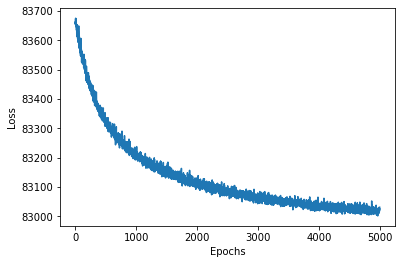

In [14]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Original images


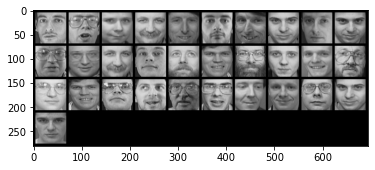

VAE reconstruction:


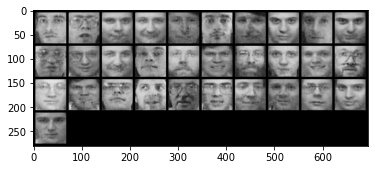

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()


def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images = iter(trainloader).next()


print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

print('VAE reconstruction:')
visualise_output(images, vae)

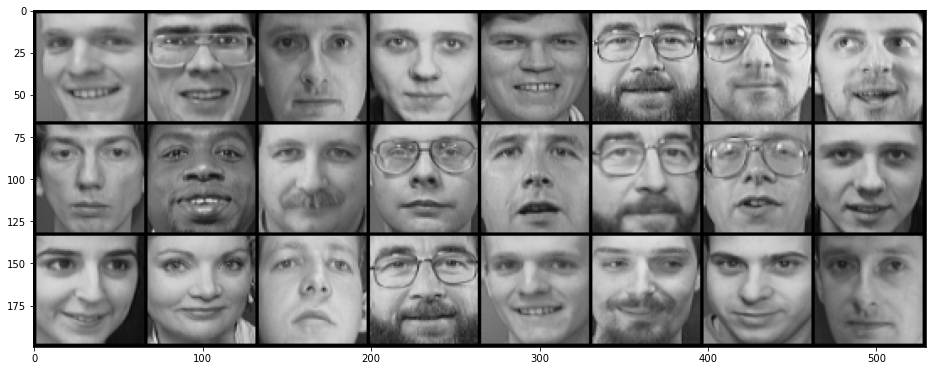

In [16]:
import numpy

samples = iter(trainloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))


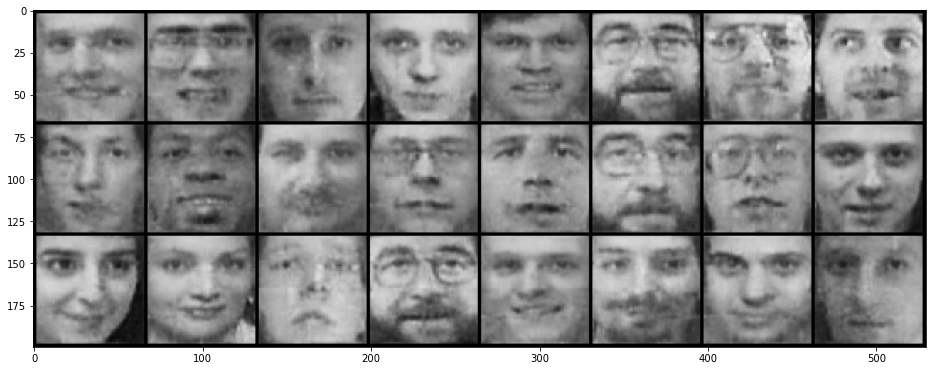

In [17]:
samples = samples.to(device='cuda', dtype=torch.float)
Results,_,_a = vae(samples)
Resluts = Results.to('cpu')
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(Results[:24])
grid_imgs = grid_imgs.to('cpu')
np_grid_imgs = grid_imgs.detach().numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

Original images


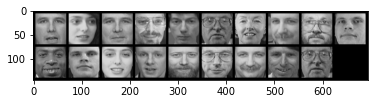

VAE reconstruction:


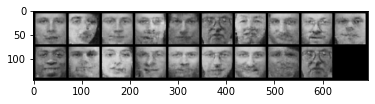

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()


def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images = iter(valloader).next()


print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

print('VAE reconstruction:')
visualise_output(images, vae)

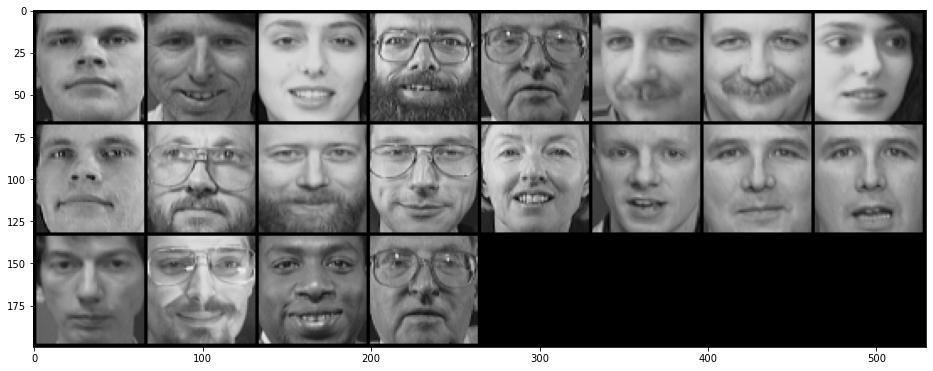

In [19]:
import numpy

samples = iter(valloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))


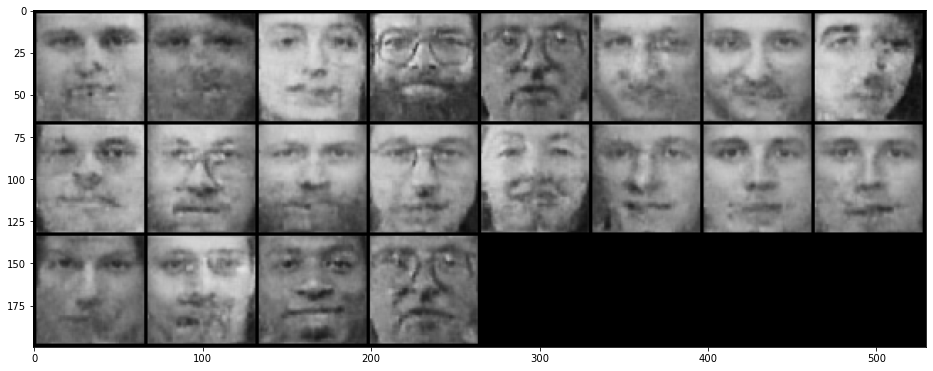

In [20]:
samples = samples.to(device='cuda', dtype=torch.float)
Results,_,_a = vae(samples)
Resluts = Results.to('cpu')
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(Results[:24])
grid_imgs = grid_imgs.to('cpu')
np_grid_imgs = grid_imgs.detach().numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

torch.Size([1, 64, 64])


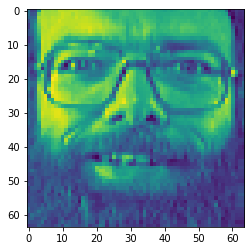

In [38]:
i1 = samples[3]
i2 = samples[4]
plt.imshow((i1.reshape((64,64))).to('cpu'))
print(i1.shape)

torch.Size([1, 64, 64])


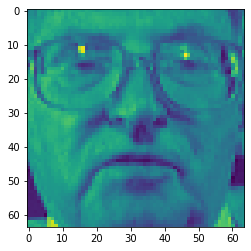

In [39]:
plt.imshow((i2.reshape((64,64))).to('cpu'))
print(i2.shape)

torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])


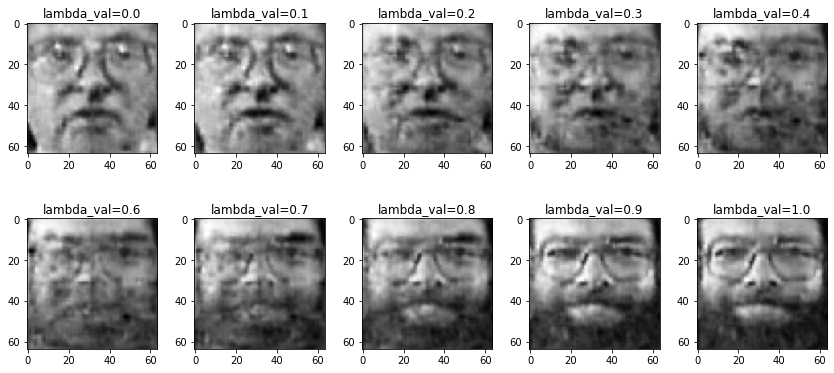

In [42]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
        
        img1 = img1.reshape((1,1,64,64))
        img2 = img2.reshape((1,1,64,64))
        # latent vector of first image
        img1 = img1.to(device)
        latent_1,_ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2,_ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae,i1,i2)
   
    inter_image = to_img(inter_image)
    
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 